Import necessary libraries. Merge the dataset and convert it to dataframe. Load the dataset.

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

base_path = "/content"

countries = ['US','IN','GB']
frames = []

In [ ]:
for c in countries:
    csv_path = os.path.join(base_path, f"{c}videos.csv")
    json_path = os.path.join(base_path, f"{c}_category_id.json")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} not found. Check base_path and file names.")
    df = pd.read_csv(csv_path)
    df['country'] = c

    # load category mapping (json)
    with open(json_path, 'r') as f:
        categories = json.load(f)
    cat_map = {int(item['id']): item['snippet']['title'] for item in categories['items']}
    df['category_name'] = df['category_id'].map(cat_map)

    frames.append(df)

Drop columns, remove na values.

In [ ]:
data = pd.concat(frames, ignore_index=True)
print("Merged rows:", len(data))
print("Columns:", list(data.columns))

Merged rows: 117217
Columns: ['video_id', 'trending_date', 'title', 'channel_title', 'category_id', 'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'description', 'country', 'category_name']


In [ ]:
data = data.drop(['comments_disabled', 'ratings_disabled', 'video_error_or_removed'], axis=1)

In [ ]:
data = data.dropna(subset=['title','views','likes','comment_count','publish_time','tags'])
data = data.reset_index(drop=True)
print("After dropping nulls:", len(data))

After dropping nulls: 117217


Use beta distribution to get views, likes, comments in first 24 hours. Get like:view and comment:view ratios of first 24 hours. Set a threshold for getting viral video criteria through views.

In [ ]:
rs = np.random.RandomState(RANDOM_STATE)
# Beta parameters chosen to simulate realistic early-share variability
a, b = 2.0, 6.0   # skewed so early counts are typically smaller than final totals

frac = rs.beta(a, b, size=len(data))  # fraction in (0,1) per video
# clamp between 0.05 and 0.6 to avoid extremely small/large values
frac = np.clip(frac, 0.05, 0.6)

data['first24_views'] = (data['views'] * frac).astype(int)
data['first24_likes'] = (data['likes'] * frac).astype(int)
data['first24_comments'] = (data['comment_count'] * frac).astype(int)

# sanity check
print("Sample simulated first24 fractions (first 5):", frac[:5])

Sample simulated first24 fractions (first 5): [0.30935913 0.21234323 0.37659901 0.13810637 0.47342336]


In [ ]:
data['like_view_ratio_24h'] = data['first24_likes'] / (data['first24_views'] + 1)
data['comment_view_ratio_24h'] = data['first24_comments'] / (data['first24_views'] + 1)

# tag count (tags are separated by | in this dataset)
data['tag_count'] = data['tags'].apply(lambda x: len(str(x).split('|')))

# title length and publish hour
data['title_length'] = data['title'].apply(lambda x: len(str(x)))
data['publish_hour'] = pd.to_datetime(data['publish_time']).dt.hour

# title sentiment (polarity: -1..1)
data['title_sentiment'] = data['title'].apply(lambda t: TextBlob(str(t)).sentiment.polarity)

# add a simple engagement index (24h)
data['engagement_24h'] = data['first24_likes'] + data['first24_comments']

In [ ]:
threshold = data['views'].quantile(0.90)
data['viral'] = np.where(data['views'] >= threshold, 1, 0)
print("Viral threshold (views):", threshold)
print("Viral distribution:\n", data['viral'].value_counts(normalize=True))

Viral threshold (views): 5876264.800000007
Viral distribution:
 viral
0    0.899997
1    0.100003
Name: proportion, dtype: float64


Assign features and target variable for training the model. 80% training set and 20% test set for Random Forest. Plot confusion matrix.

In [ ]:
feature_cols = [
    'first24_views', 'first24_likes', 'first24_comments',
    'like_view_ratio_24h', 'comment_view_ratio_24h',
    'tag_count', 'title_length', 'publish_hour', 'title_sentiment',
    'engagement_24h'
]
# Ensure no infinite/NaN values
X = data[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
y = data['viral']

# quick shape
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (117217, 10) y shape: (117217,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# ------------------------------
# 8) Random Forest classifier
# ------------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print("\nRandom Forest Accuracy: {:.3f}".format(rf_acc))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.973
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     21100
           1       0.91      0.81      0.86      2344

    accuracy                           0.97     23444
   macro avg       0.95      0.90      0.92     23444
weighted avg       0.97      0.97      0.97     23444



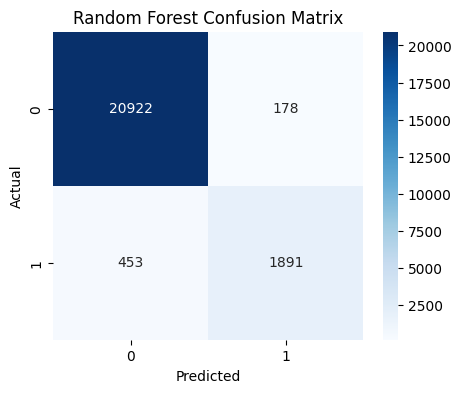

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Train XGBoost model. Plot confusion matrix. Box plot of like:view ratio of first 24 hours.

In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=6,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print("\nXGBoost Accuracy: {:.3f}".format(xgb_acc))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:10:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Accuracy: 0.978
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     21100
           1       0.94      0.84      0.89      2344

    accuracy                           0.98     23444
   macro avg       0.96      0.92      0.94     23444
weighted avg       0.98      0.98      0.98     23444



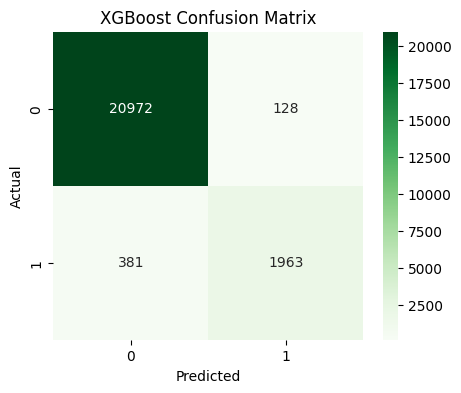

In [ ]:
cm2 = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

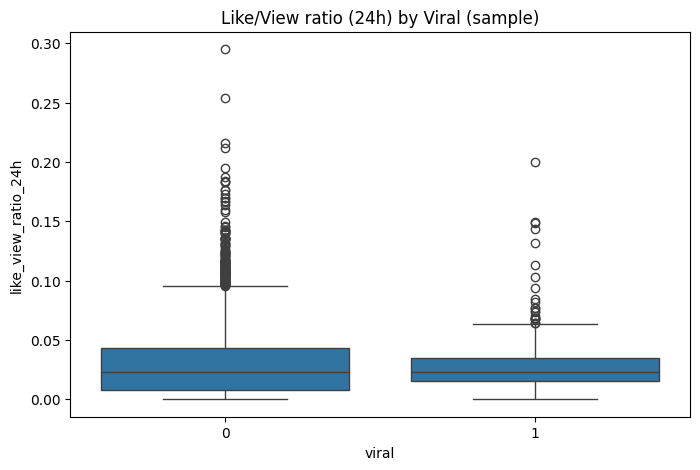

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='viral', y='like_view_ratio_24h', data=data.sample(n=5000, random_state=RANDOM_STATE))
plt.title("Like/View ratio (24h) by Viral (sample)")
plt.show()

Test XGBoost and Random Forest model. Remove commercial channels to focus on content creator videos.

In [ ]:
# Pick a random sample video from the test set
sample_index = np.random.randint(0, len(X_test))
sample_video = X_test.iloc[[sample_index]]

# Fetch the video title and channel name from the original dataset
video_title = data.loc[sample_index, 'title']
channel_name = data.loc[sample_index, 'channel_title']

# Get the model's predicted class (0 = non-viral, 1 = viral)
pred_label = xgb.predict(sample_video)[0]

# Display prediction result
print(f"🎬 Video Title: {video_title}")
print(f"📺 Channel: {channel_name}")
if pred_label == 1:
    print("🔥 This video is predicted to go VIRAL!")
else:
    print("❄️ This video is predicted to be NON-VIRAL.")

🎬 Video Title: Good Odds | Toyota
📺 Channel: Toyota Global
🔥 This video is predicted to go VIRAL!


In [ ]:
# Pick a random sample video from the test set
sample_index = np.random.randint(0, len(X_test))
sample_video = X_test.iloc[[sample_index]]

# Fetch the video title and channel name from the original dataset
video_title = data.loc[sample_index, 'title']
channel_name = data.loc[sample_index, 'channel_title']

# Get the model's predicted class (0 = non-viral, 1 = viral)
pred_label = rf.predict(sample_video)[0]

# Display prediction result
print(f"🎬 Video Title: {video_title}")
print(f"📺 Channel: {channel_name}")
if pred_label == 1:
    print("🔥 This video is predicted to go VIRAL!")
else:
    print("❄️ This video is predicted to be NON-VIRAL.")

🎬 Video Title: Dua Lipa - Golden Slumbers
📺 Channel: Dua Lipa
❄️ This video is predicted to be NON-VIRAL.


In [ ]:
# ================================================================
# 🚫 Remove Commercial / Brand / Music / Movie / Corporate Channels
# ================================================================

exclude_keywords = [
    "official trailer", "music video", "song", "teaser",
    "trailer", "lyric", "video song", "motion poster",
    "promo", "film", "movie", "soundtrack", "records",
    "studio", "entertainment", "t-series", "zee", "saregama",
    "sonymusic", "marvel", "warner bros"
]

# List of entertainment, music, and corporate channels to exclude
excluded_channels = [
    'Marvel Entertainment', 'Sony Pictures Entertainment', 'YouTube Spotlight', 'FoxStarHindi',
    'LuisFonsiVEVO', 'Universal Pictures', 'ibighit', 'TaylorSwiftVEVO', 'Bruno Mars', 'jbalvinVEVO',
    'HBO', 'Disneyâ¢Pixar', 'Paramount Pictures', 'Maroon5VEVO', 'T-Mobile', 'Jeep', 'NFL',
    'Ed Sheeran', 'Apple', 'SpaceX', 'Cardi B', '20th Century Fox',
    'The Tonight Show Starring Jimmy Fallon', 'SelenaGomezVEVO', 'BeckyGVEVO', 'shakiraVEVO',
    'DemiLovatoVEVO', 'WWE', 'WIRED', 'Star Wars', 'justintimberlakeVEVO',
    'Jimmy Kimmel Live', 'Dua Lipa', 'The Late Late Show with James Corden',
    'EminemVEVO', 'The Official PokÃ©mon YouTube channel', 'NickiMinajAtVEVO', 'Vevo',
    'NickyJamTV', 'PBS NewsHour', 'OVO Sound', 'MigosVEVO', 'Disney Movie Trailers', 'SMTOWN',
    'KendrickLamarVEVO', 'BANGTANTV', 'ZEDDVEVO', 'Walt Disney Animation Studios', 'Bethesda Softworks',
    'ChainsmokersVEVO', 'Cobra Kai', 'Warner Bros. Picture', 'Saturday Night Live', 'Gorillaz',
    'NBC', 'Hannah Stocking', 'Super Netvid', 'FamilyFeud', 'TheEllenShow', 'Kylie Jenner',
    'Warner Bros. Pictures', 'Fifty Shades', 'Kanye West', 'CelineDionVEVO', 'Tide', 'Vogue',
    'Nintendo', 'MLG Highlights', 'CamilaCabelloVEVO', 'BackstreetBoysVEVO', '1theK (ìëì¼ì´)',
    'ShawnMendesVEVO', 'ESPN', 'TWICE JAPAN OFFICIAL YouTube Channel', 'KatyPerryVEVO',
    'PinkVEVO', 'Battlefield', 'CAguileraVEVO', 'FiftyShadesVEVO',
    'The Late Show with Stephen Colbert', 'Nicki Minaj', 'ZaynVEVO', 'Pitch Perfect',
    'Mnet K-POP', 'BuzzFeedVideo', 'The Daily Show with Trevor Noah', 'Google Developers',
    'Adult Swim', 'Shawn Mendes', 'CalvinHarrisVEVO', 'Team Coco', 'EverythingApplePro',
    'BURGER KING', 'BBC Radio 1', 'Disney Descendants', 'æ°å¨ç¾é³æ¨ JVR Musi',
    'TIME', 'Netflix', 'TODAY', 'ONE Media', 'HalseyVEVO', 'Breakfast Club Power 105.1 FM',
    'The Voice', 'Oscars', 'carrieunderwoodVEVO', 'LouisTomlinsonVEVO', 'GEazyMusicVEVO',
    'Washington Post', 'KhalidVEVO', 'PlayStation', 'CNN', 'CollegeHumor', 'TroyeSivanVEVO',
    'Snapchat', 'Prince', 'EntertainmentVevo', 'ThomasRhettVEVO', 'RemyMaVEVO', 'NFL Network',
    'TMZ', 'CBS Los Angeles', 'Gordon Ramsay', 'Will Smith', 'The X Factor UK', 'Vanity Fair',
    'ET Canada', 'American Idol', 'NBA on TNT', 'The Verge', 'Amazon Studios', 'SamSmithWorldVEVO',
    'FallOutBoyVEVO', 'ExplosmEntertainment', 'Jeopardy!', 'LadyGagaVEVO', 'Groupon',
    'DJSnakeVEVO', 'PokÃ©mon GO', 'Recording Academy / GRAMMYs', 'KBSKpop', 'NBA', 'SiaVEVO',
    '5FDPVEVO', 'FrenchMontanaVEVO', 'NBC Sports', 'Google', 'LuisFonsiVEVO', 'Marshmello',
    "America's Got Talent", 'gameslice'
]

# Remove those channels
data = data[~data["channel_title"].isin(excluded_channels)].copy()

print(f"✅ After channel elimination: {len(data)} rows remain.")

✅ After channel elimination: 100331 rows remain.


Retain creator-type videos. Clean title text. Specify X and Y for Naive Bayes training.

In [ ]:
mask = ~data["title"].str.lower().str.contains("|".join(exclude_keywords), na=False)
creator_df = data[mask].copy()

print(f"✅ Retained {len(creator_df)} creator-type videos (out of {len(data)} total)")

✅ Retained 84877 creator-type videos (out of 100331 total)


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

creator_df["clean_title"] = creator_df["title"].astype(str).apply(clean_text)

In [ ]:
X = creator_df["clean_title"]
y = creator_df["viral"]  # same viral label as Part A

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

Apply TF-IDF vectorization for getting clear idea of most impactful words that occur in title of video. Train Multinomial Naive Bayes model. Get graph of top words that boost virality.

In [ ]:
# ------------------------------------------------
# 4️⃣  TF-IDF vectorization
# ------------------------------------------------
tfidf = TfidfVectorizer(
    stop_words="english", max_features=3000, ngram_range=(1, 2)
)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
y_pred_nb = nb.predict(X_test_vec)

# ------------------------------------------------
# 6️⃣  Evaluate model
# ------------------------------------------------
print("\n📊  NLP Model Performance")
print("Accuracy:", round(accuracy_score(y_test, y_pred_nb), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


📊  NLP Model Performance
Accuracy: 0.96

Confusion Matrix:
 [[19524   343]
 [  505   848]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     19867
           1       0.71      0.63      0.67      1353

    accuracy                           0.96     21220
   macro avg       0.84      0.80      0.82     21220
weighted avg       0.96      0.96      0.96     21220



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


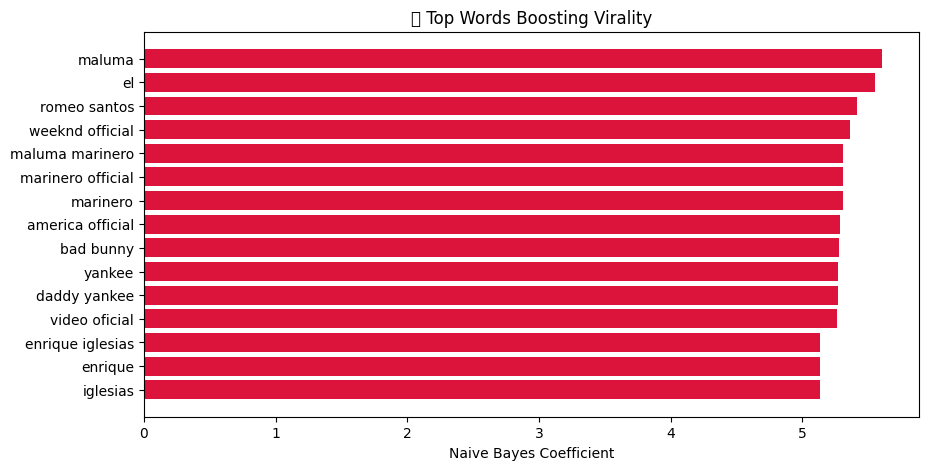

In [ ]:
feature_names = np.array(tfidf.get_feature_names_out())
coefs = nb.feature_log_prob_[1] - nb.feature_log_prob_[0]

top_pos_idx = np.argsort(coefs)[-15:][::-1]
top_neg_idx = np.argsort(coefs)[:15]

top_pos_words = feature_names[top_pos_idx]
top_neg_words = feature_names[top_neg_idx]

plt.figure(figsize=(10, 5))
plt.barh(top_pos_words[::-1], coefs[top_pos_idx][::-1], color="crimson")
plt.title("🔥 Top Words Boosting Virality")
plt.xlabel("Naive Bayes Coefficient")
plt.show()

Plot word cloud, graph of words occuring in titles of non-viral videos. Apply hyperparameter tuning by K-fold cross validation.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2965 (\N{TAMIL LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Tamil natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/I

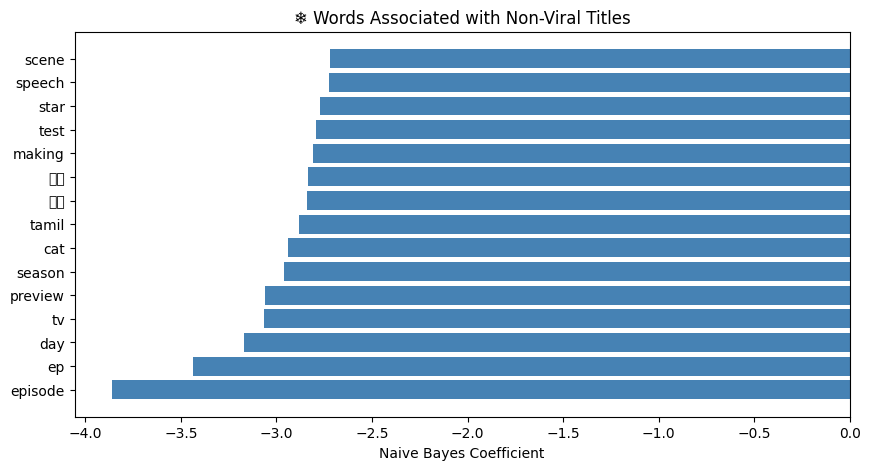

In [ ]:
plt.figure(figsize=(10, 5))
plt.barh(top_neg_words, coefs[top_neg_idx], color="steelblue")
plt.title("❄️ Words Associated with Non-Viral Titles")
plt.xlabel("Naive Bayes Coefficient")
plt.show()

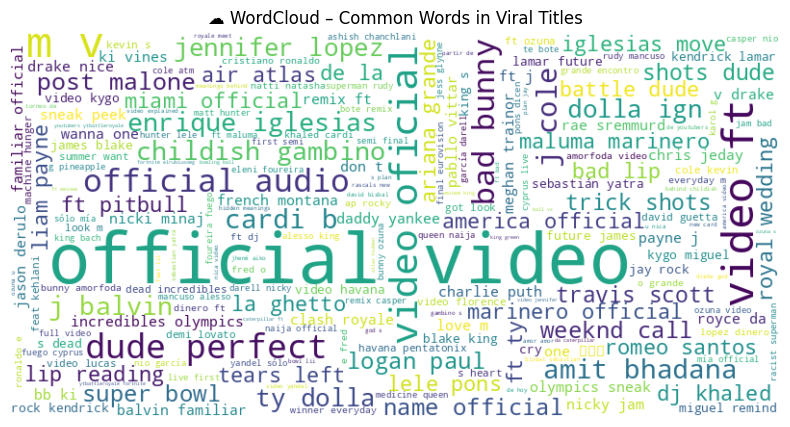

In [ ]:
viral_titles = " ".join(creator_df[creator_df["viral"] == 1]["clean_title"])
wc = WordCloud(width=800, height=400, background_color="white").generate(viral_titles)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("☁️ WordCloud – Common Words in Viral Titles")
plt.show()

In [ ]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y.iloc[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y.iloc[test]) # evaluate score function on held-out data
    return result / nfold # average

Use countvectoriser to get context around each word. Apply stopwords to get better results of prediction.

In [ ]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    good = y
    bad = ~good
    return prob[good, 0].sum() + prob[bad, 1].sum()

In [ ]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(creator_df.shape[0]), train_size=0.7)
mask = np.zeros(creator_df.shape[0], dtype=np.bool)
mask[itest] = True

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import string
import nltk
nltk.download('stopwords')
import re

text = creator_df.title
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

# we set ngram_range for the CountVectorizer to get context around each word
vectorizer = CountVectorizer(min_df=1, analyzer='word', ngram_range=(3, 3))

# we create a function that will get rid of punctuations, tokenize, stem and remove stopwords
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

clean_text(text)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

def make_xy(ctry_elim, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (creator_df.views >= 580000)  # this is the threshold for 50% of the videos in this set
    return X, y
X, y = make_xy(creator_df)

#the grid of parameters to search over
alphas = [.1, 1, 5]
min_dfs = [1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df = min_df)
        Xthis, ythis = make_xy(creator_df, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

<>:19: SyntaxWarning: invalid escape sequence '\W'
<>:19: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipython-input-139126681.py:19: SyntaxWarning: invalid escape sequence '\W'
  tokens = re.split('\W+', text)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Get good and bad words using hyper parameter tuned 'clf' model. Predict using this model.

In [ ]:
print("best alpha: {}".format(best_alpha))
print("min_df: {}".format(best_min_df))
print("best score: {}".format(maxscore))
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(creator_df, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

best alpha: 5
min_df: 1
best score: -11303.184266125148
Accuracy on training data: 0.848571
Accuracy on test data:     0.815125


In [ ]:
words = np.array(vectorizer.get_feature_names_out())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:100]]
bad_words = words[ind[-100:]]

good_prob = probs[ind[:100]]
bad_prob = probs[ind[-100:]]

print("Good words\t     P(good | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

print("Bad words\t     P(good | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(good | word)
               ozuna 0.94
             oficial 0.93
              closer 0.91
                  el 0.91
              spider 0.91
                 dir 0.91
              grande 0.91
                yiay 0.90
              maluma 0.90
                 byn 0.89
               bunny 0.89
               ninja 0.89
                kygo 0.88
                lele 0.88
                pons 0.88
          pentatonix 0.88
              ariana 0.88
           seventeen 0.88
                cole 0.87
               zones 0.87
              havana 0.87
                puth 0.87
               dolla 0.87
              babish 0.87
             trainor 0.86
              balvin 0.86
             enrique 0.86
                  ty 0.86
            iglesias 0.86
           primitive 0.86
             bhadana 0.86
               tears 0.86
               disco 0.86
             ronaldo 0.86
             shinoda 0.86
              zoella 0.86
                  mv 0.85
       

In [ ]:
clf.predict_proba(vectorizer.transform(['top 10 ways to make money working from home in 6 months']))

array([[0.71746405, 0.28253595]])